# Bayesian Cellular Segmentation Benchmark

The following code should be preferably opened in Google Colab, using this link : 


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IhabBendidi/Bayesian_Cellular_Segmentation/blob/main/Cell_Segmentation_Bayesian.ipynb)

*Author : Ihab Bendidi*

In this project, we aim to compare the performance and results of the classic standard U-Net architecture and the bayesian U-Net architecture, on a cellular segmentation task, using a dataset composed of different kinds of cells, in different representations.

## I - Data Preparation & Pipelines

One of the first and important steps is to prepare and process data. We would be taking the data from Kaggle, which would be processed in different ways for both standard U-Net and the Bayesian U-Net. But before that, we install all dependencies.

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/clementsiegrist/segmentation_probabilisticDL/main/requirements.txt 
!pip3 install -r requirements.txt
!pip3 install --upgrade --force-reinstall --no-deps kaggle

We import the libraries we'll be using throughout the project.

In [ ]:
import os
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

Our next step is to download the data from Kaggle and prepare it in a specific folder. Please check the report to understand how data was chosen and prepared.

In [ ]:
# Bayesian U-Net
%%capture
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json


api_token = {"username":"bendidihab","key":"6b534264cbd90d4cc3f040b1894cb226"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)


!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!kaggle competitions download -c data-science-bowl-2018
!unzip /content/{/content}/competitions/data-science-bowl-2018/data-science-bowl-2018.zip
!mkdir /content/train
!mv -i /content/stage1_train.zip /content/train
!cd /content/train && unzip /content/train/stage1_train.zip
!mkdir /content/data && mkdir /content/data/train && mkdir /content/data/test
!rm -rf /content/stage1_sample_submission.csv.zip /content/stage1_solution.csv.zip /content/stage1_test.zip /content/stage1_train_labels.csv.zip /content/stage2_sample_submission_final.csv.zip /content/stage2_test_final.zip

We can visualize some images of our raw unprepared dataset, where we can notice that the cell segmentation labels are separate for each cell in the raw image.


An Example of an image used : 



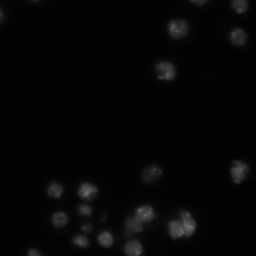


One image of the segmentation label of one cell in the image : 



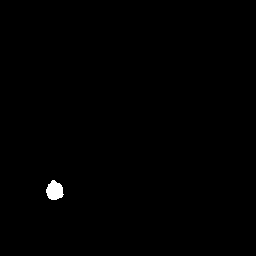


One image of the segmentation label of another cell in the image : 



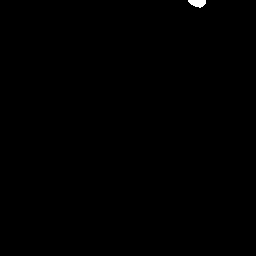

In [ ]:
img = cv.imread('/content/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')
mask1 = cv.imread('/content/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png')
mask2 = cv.imread('/content/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/be98de8a7ba7d5d733b1212ae957f37b5b69d0bf350b9a5a25ba4346c29e49f7.png')
print("\nAn Example of an image used : \n")
cv2_imshow(img)
print("\nOne image of the segmentation label of one cell in the image : \n")
cv2_imshow(mask1)
print("\nOne image of the segmentation label of another cell in the image : \n")
cv2_imshow(mask2)

We use the following code to fuse all the label segmentations of cells into one image that corresponds to its accompagnying raw image, followed by a bit of image processing.

In [ ]:
# Bayesian U-Net
i = 1
train_percent = 0.7
data_size = 670
dim = (640,480)
path = '/content/train'
list_subfolders_with_paths = [f.path for f in os.scandir(path) if f.is_dir()]
train_size = int(data_size*train_percent)
test_size = data_size - train_size
for sub in list_subfolders_with_paths :
  folder_types = [f.path for f in os.scandir(sub) if f.is_dir()]
  if i < train_size : 
    os.mkdir('data/train/OP'+str(i))
  else :
    os.mkdir('data/test/OP'+str(i))
  for f_type in folder_types :
    if f_type.split('/')[-1] == 'masks': 
      onlyfiles = [f for f in os.listdir(f_type) if os.path.isfile(os.path.join(f_type, f))]
      src = f_type + '/' + onlyfiles[0]
      src1 = cv.imread(src)
      for img in onlyfiles : 
        src2 = cv.imread(f_type + '/' + img)
        alpha = 1
        beta = 1
        src1 = cv.addWeighted(src1, alpha, src2, beta, 0.0)
      img = cv.resize(src1, dim, interpolation = cv.INTER_AREA)
      if i < train_size :
        cv.imwrite('data/train/OP'+str(i)+'/img_' + str(i) + '_class.png',img)
      else :
        cv.imwrite('data/test/OP'+str(i)+'/img_' + str(i) + '_class.png',img)
    if f_type.split('/')[-1] == 'images':
      onlyfiles = [f for f in os.listdir(f_type) if os.path.isfile(os.path.join(f_type, f))]
      img_raw = cv.imread(f_type + '/' + onlyfiles[0])
      img = cv.resize(img_raw, dim, interpolation = cv.INTER_AREA)
      if i < train_size :
        cv.imwrite('data/train/OP'+str(i)+'/img_' + str(i) + '_raw.png',img)
      else :
        cv.imwrite('data/test/OP'+str(i)+'/img_' + str(i) + '_raw.png',img)
  i += 1
!rm -rf /content/train /content/{

We can see the results of our earlier manipulation here : 


An Example of an image used : 



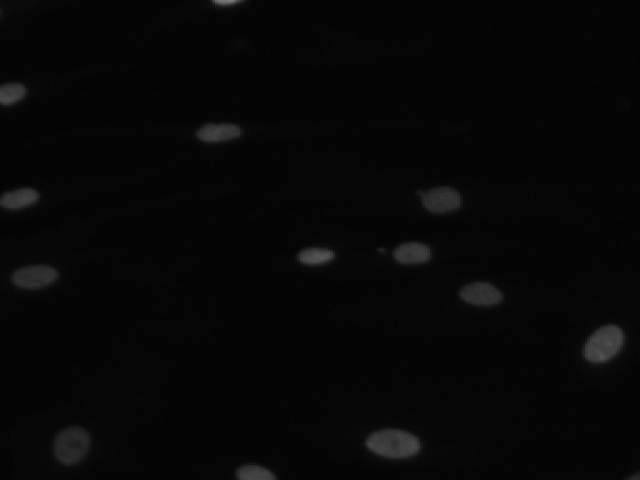


The fused image segmentation: 



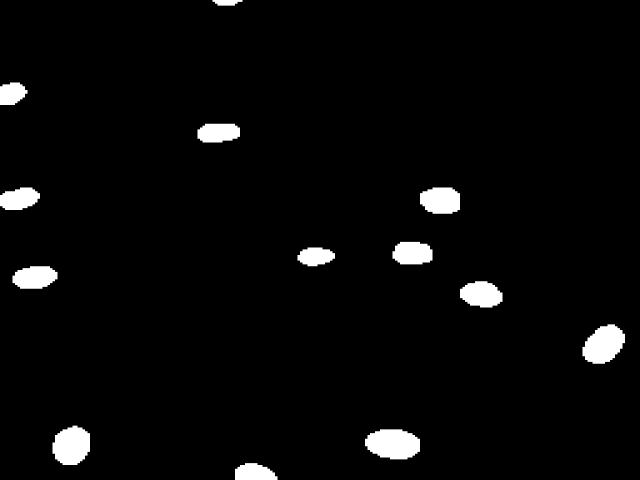

In [ ]:
img = cv.imread('/content/data/train/OP1/img_1_raw.png')
mask = cv.imread('/content/data/train/OP1/img_1_class.png')
print("\nAn Example of an image used : \n")
cv2_imshow(img)
print("\nThe fused image segmentation: \n")
cv2_imshow(mask)

The final step in our data preparation pipeline is importing our code for the pytorch based bayesian model, as well as installing all the linked dependencies.

In [ ]:
# Bayesian U-Net
%%capture
!git clone https://github.com/yuta-hi/pytorch-trainer
!cd pytorch-trainer && python setup.py install
!git clone https://github.com/IhabBendidi/pytorch_bayesian_unet 
!cd pytorch_bayesian_unet && pip install -r requirements.txt && python setup.py install
!cp -r /content/data/train /content/pytorch_bayesian_unet/examples/cellular_segmentation/train
!cp -r /content/data/test /content/pytorch_bayesian_unet/examples/cellular_segmentation/test

## II - Model Training : Bayesian U-Net

In this step, we train the bayesian model. We begin by launching another preprocessing step on the data. We replace all the white spots in label images by 1-values, and background as 0

In [ ]:
%cd /content/

In [ ]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/preprocess.py

# train images: 467
100% 467/467 [00:00<00:00, 2754.38it/s]
# train labels: 467
100% 467/467 [00:02<00:00, 201.98it/s]
# test images: 203
100% 203/203 [00:00<00:00, 3428.24it/s]
# test labels: 203
100% 203/203 [00:00<00:00, 205.48it/s]


We then launch the training, which would go on for 3000 iteration, on the training and validation data. Results of progess of the model would be saved continuously in a logs folder in the notebook's location.

In [ ]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/train_and_test_epistemic.py --iteration 3000

GPU: cuda:0
# Minibatch-size: 2

# classes: 2
# samples:
-- train: 421
-- valid: 46
iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
0                       1.75348e+08                          0.332667                  4.55163       
100         100546                            0.882834                                 45.6211       
     total [#.................................................]  3.33%
this epoch [#######################...........................] 47.51%
       100 iter, 0 epoch / 3000 iterations
       inf iters/sec. Estimated time to finish: 0:00:00.
200         84921.8                           0.898841                                 93.4195       
     total [###...............................................]  6.67%
this epoch [###############################################...] 95.01%
       200 iter, 0 epoch / 3000 iterations
    2.0921 iters/sec. Estimated time to finish: 0:22:18.353923.
300         77261.7

We then attempt to test the model on test data to understand its generalization power on unseen data. Detailled results are then saved in the logs folder, which would be visualized later on.

In [ ]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/train_and_test_epistemic.py --test_on_test

GPU: cuda:0
# Minibatch-size: 2

# samples:
-- test: 203
Loaded a snapshot: logs/predictor_iter_00003000.pth


We can see in the two following images, the evolution of the loss and accuracy through training.

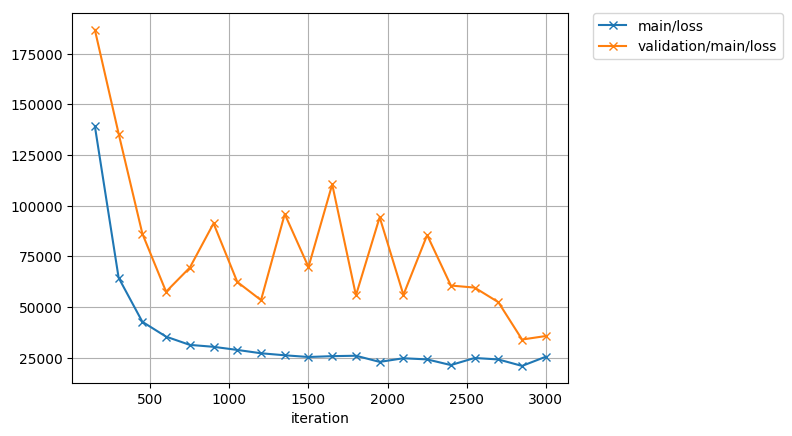

In [ ]:
img = cv.imread("/content/logs/loss.png")
cv2_imshow(img)

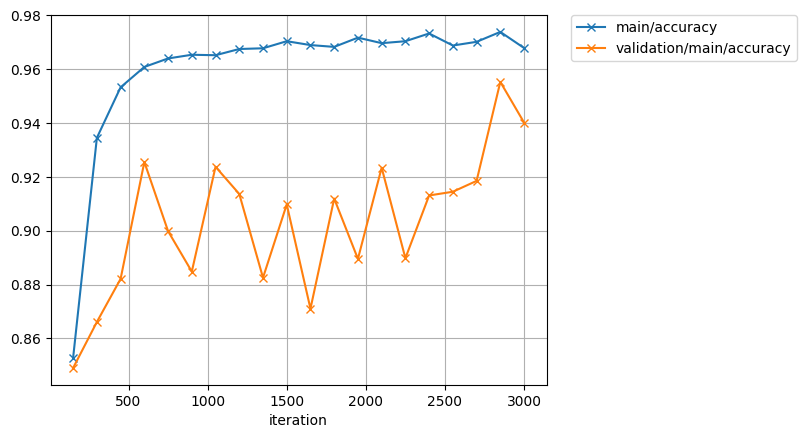

In [ ]:
img = cv.imread("/content/logs/accuracy.png")
cv2_imshow(img)

## III - Results & Comparison : Bayesian U-Net

Here we would begin by showing the progress of the training in the bayesian models.

In the following images, the first image on the left is the raw image, the second image on the left is the prediction, and the fourth image (starting from the left) are the ground truth labels.

In this following image, we see the predictions made by our model on its very first iteration of training on validation data.

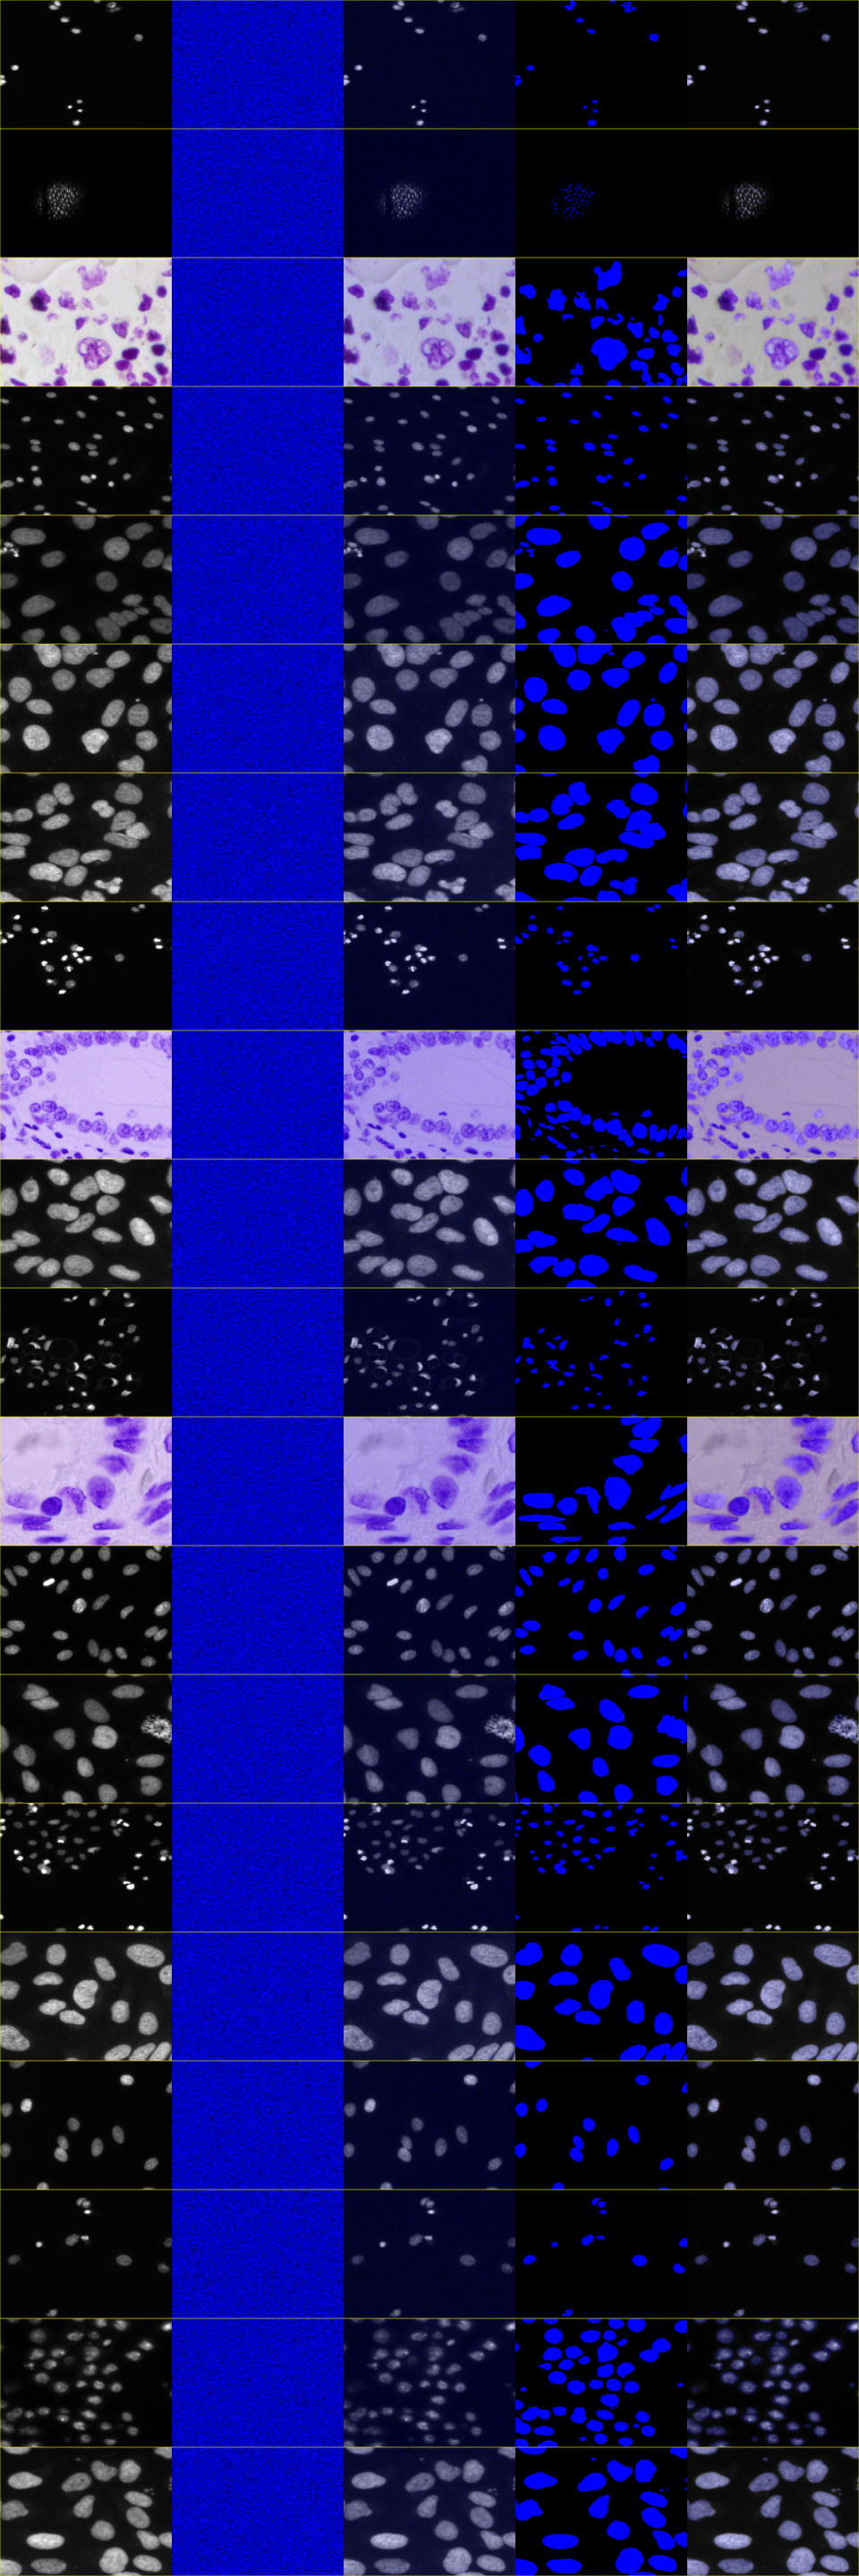

In [ ]:
img = cv.imread("/content/logs/validation/iter_00000000.png")
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
cv2_imshow(img)

In this next image, we can see the results on the validation data after 150 iteration. They are getting more precise, but we still notice a lot of mistakes.

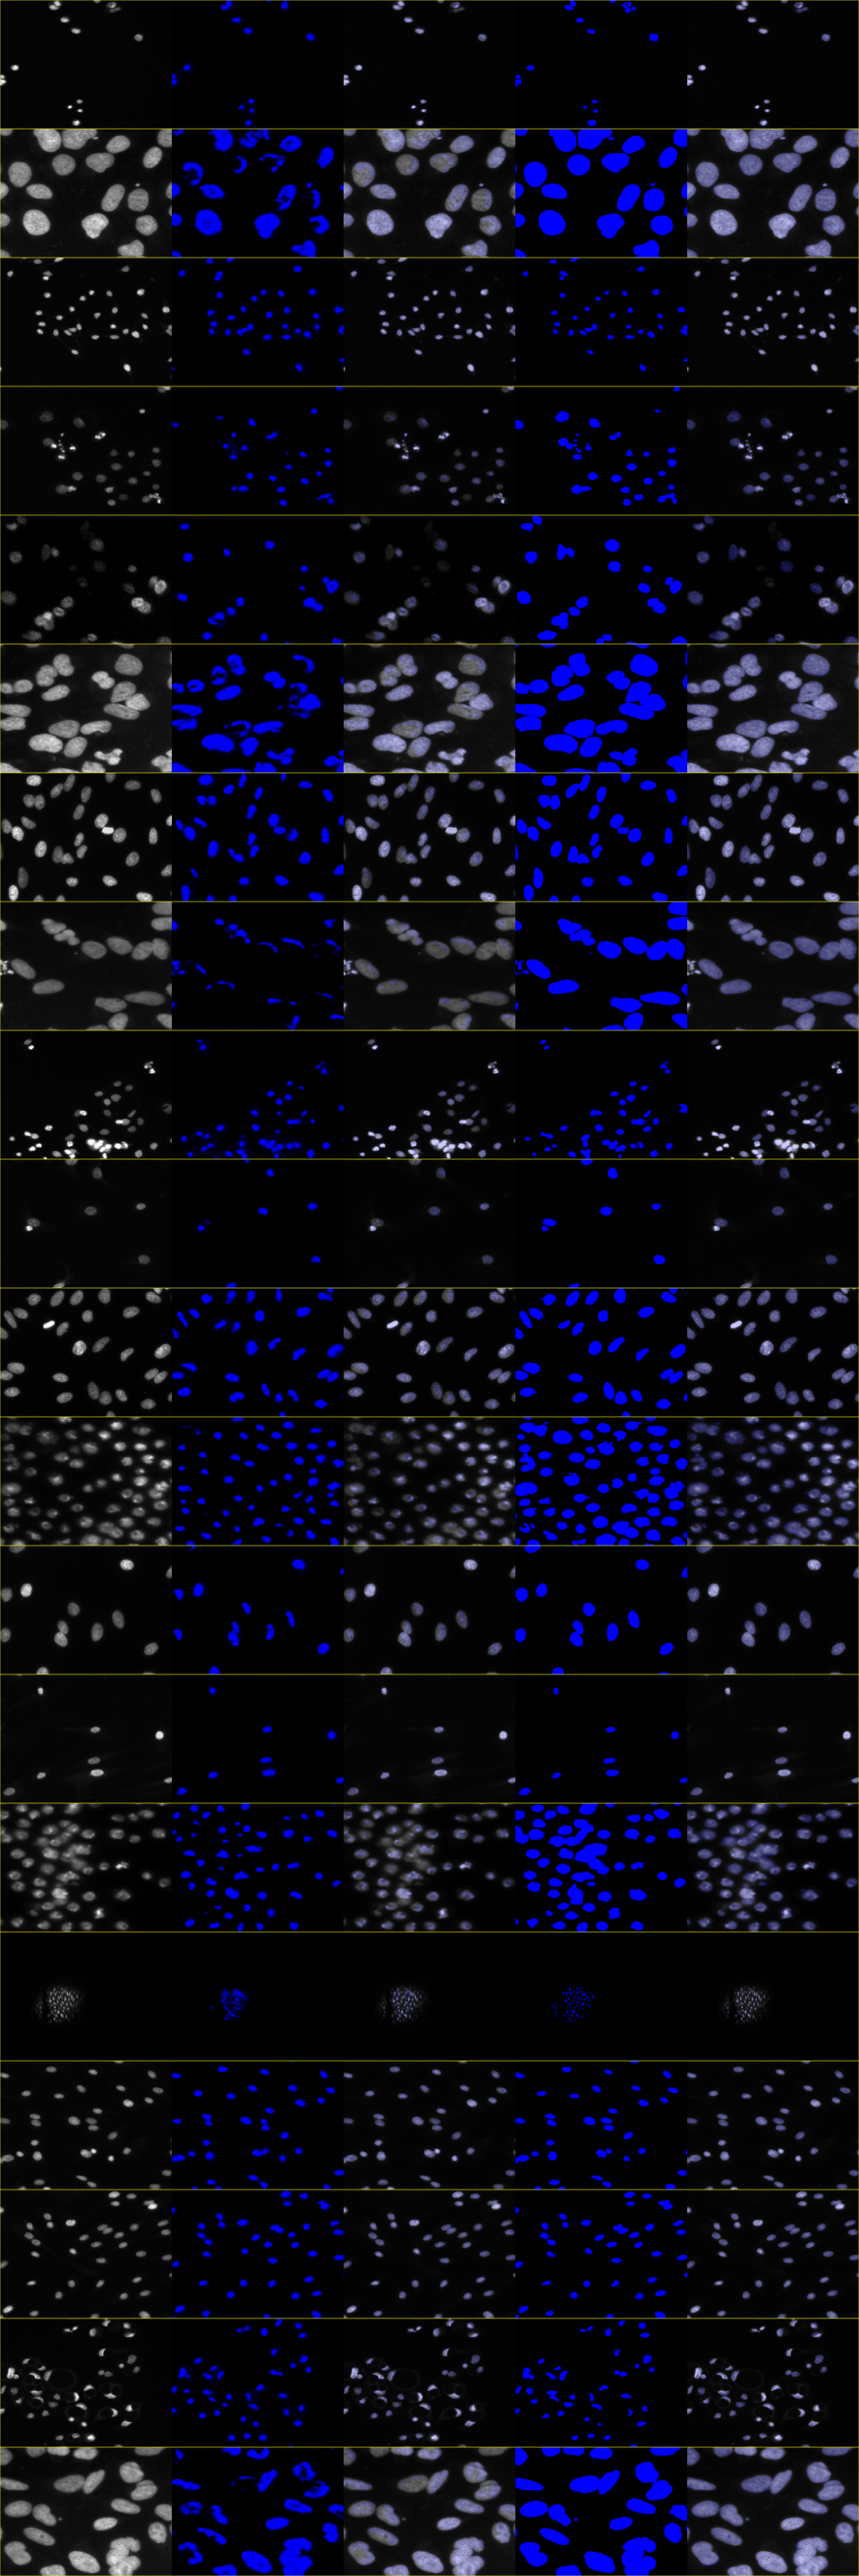

In [ ]:
img = cv.imread("/content/logs/validation/iter_00000150.png")
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
cv2_imshow(img)

Here are the prediction results of the 3000th iteration, we notice that the results got extremely precise except some very few cases.

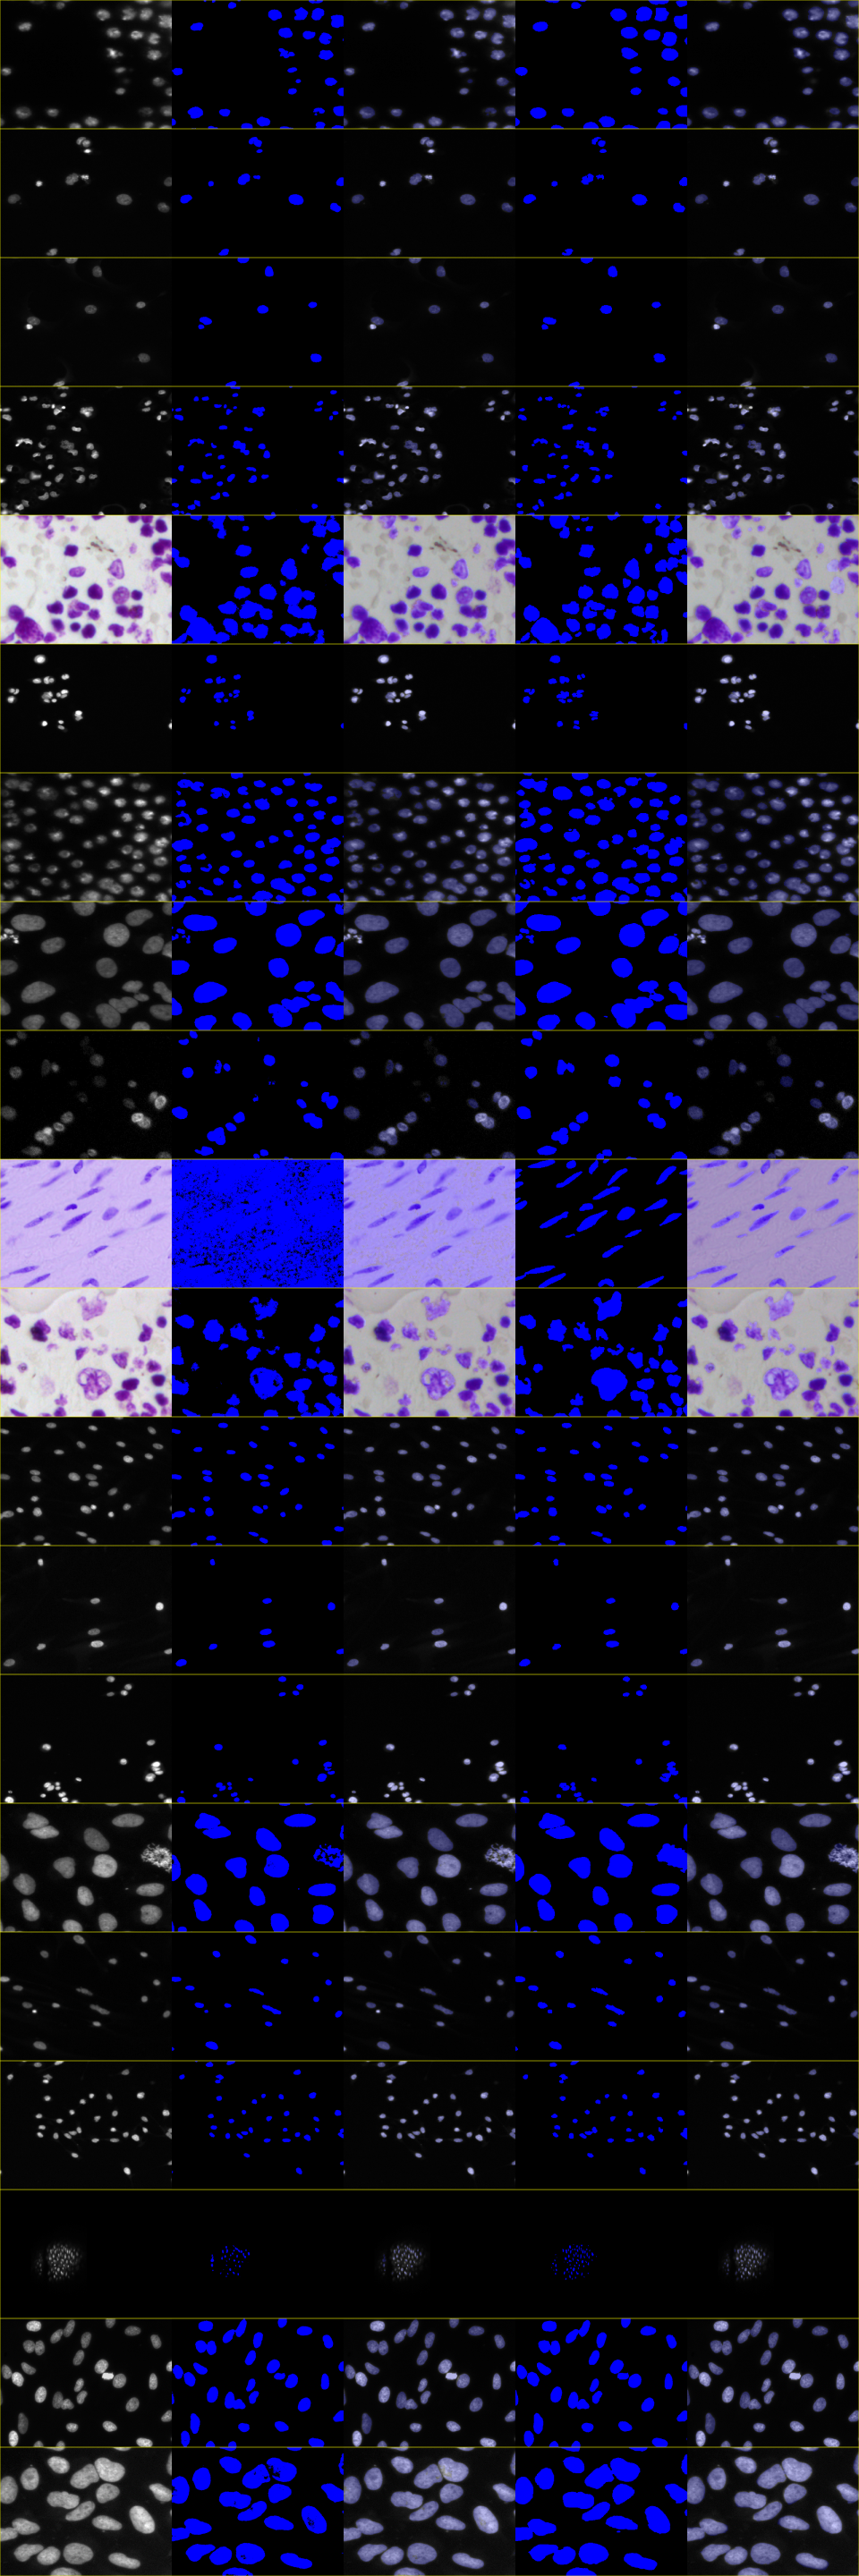

In [ ]:
img = cv.imread("/content/logs/validation/iter_00003000.png")
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
cv2_imshow(img)

We show here the results of our predictions on the test data. The DC is the certainty score (DICE value), that shows how certain the model is of his prediction. We also get a predicted variance of the image.

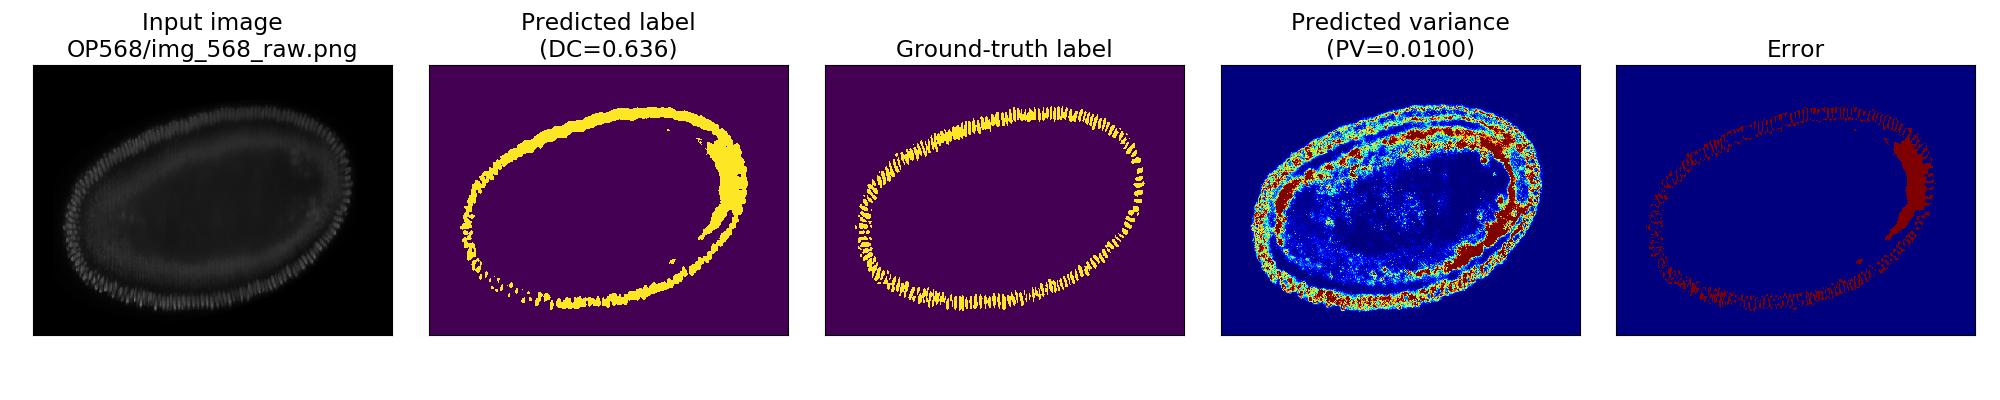

In [ ]:
img = cv.imread("/content/logs/test/001.png")
cv2_imshow(img)

We show here images where the model got high certainties

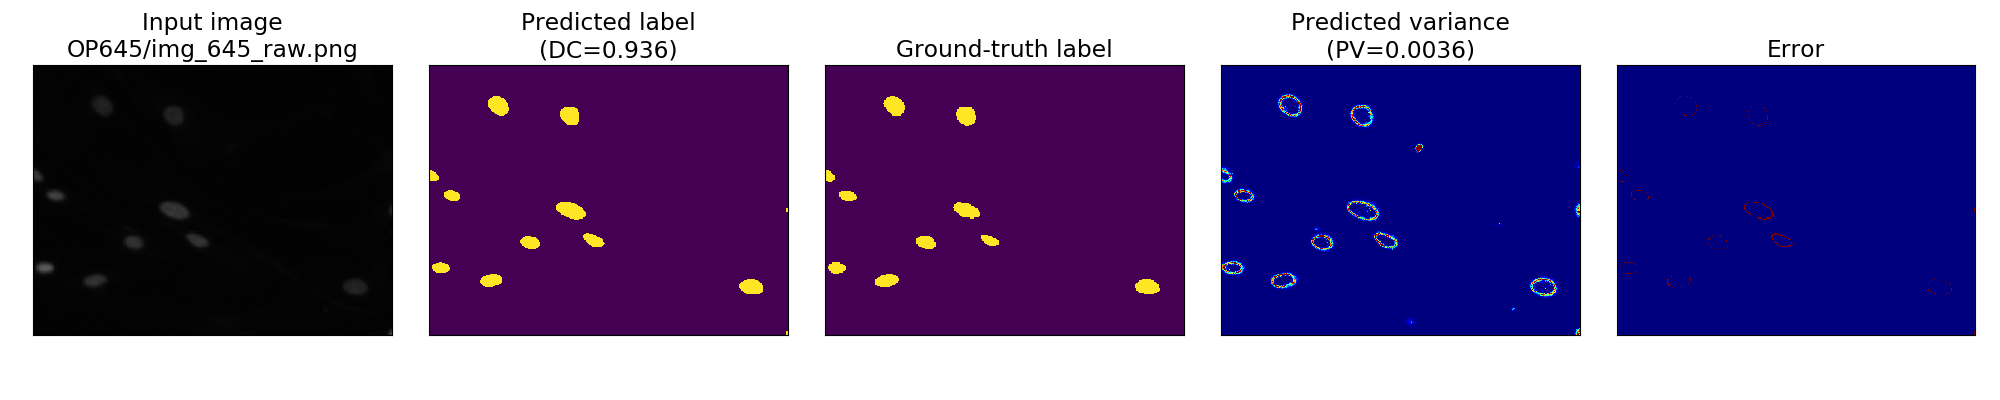

In [ ]:
img = cv.imread("/content/logs/test/004.png")
cv2_imshow(img)

We also can find that for some cells that are not well detected. But we also notice that the certainty score is very low, which shows that the model realizes its not certain of its decision and require human revision.

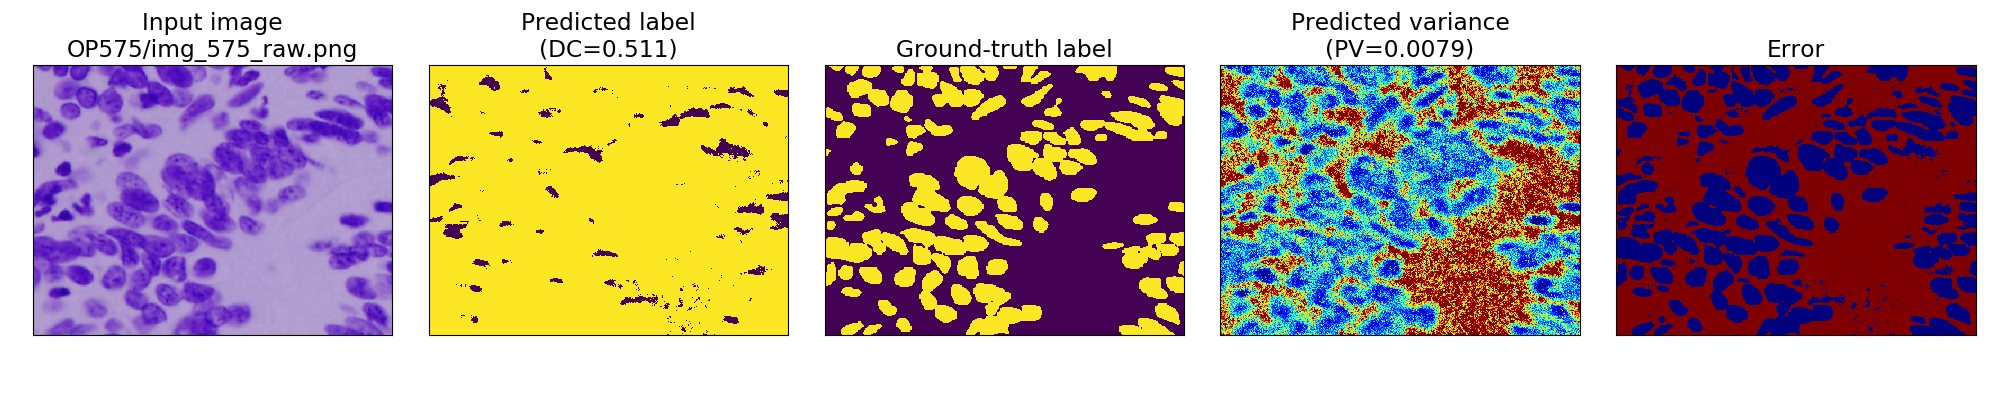

In [ ]:
img = cv.imread("/content/logs/test/000.png")
cv2_imshow(img)